# Embryoid body development - Initial state identification

Construct CytoTRACE score for embryoid body development and analyse data with the _CytoTRACEKernel_.

## Library imports

In [1]:
import sys

import matplotlib.pyplot as plt
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv

from cr2 import running_in_notebook

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

In [4]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / "cytotrace_kernel" / "embryoid_body").mkdir(parents=True, exist_ok=True)

FIGURE_FORMAT = "pdf"

## Data loading

In [5]:
adata = sc.read(DATA_DIR / "embryoid_body" / "embryoid_body.h5ad")
adata

AnnData object with n_obs × n_vars = 31029 × 19122
    obs: 'stage', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

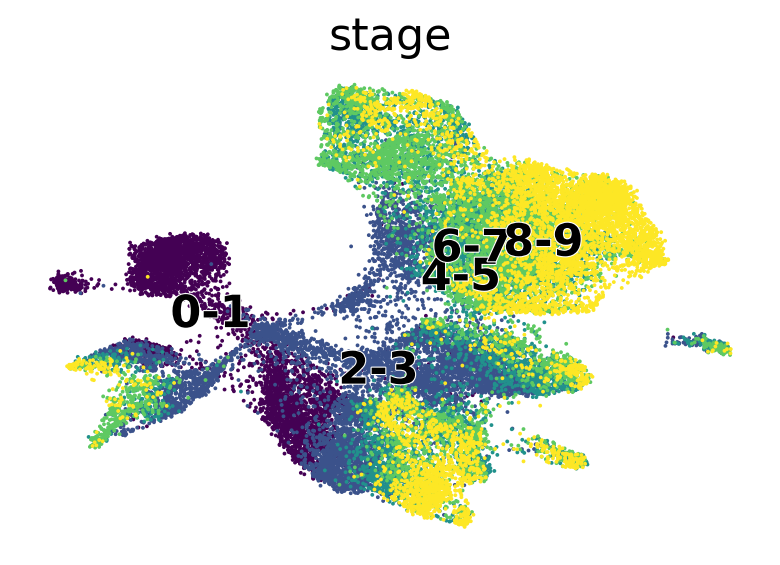

In [6]:
if running_in_notebook():
    scv.pl.scatter(adata, basis="umap", c="stage", palette="viridis")

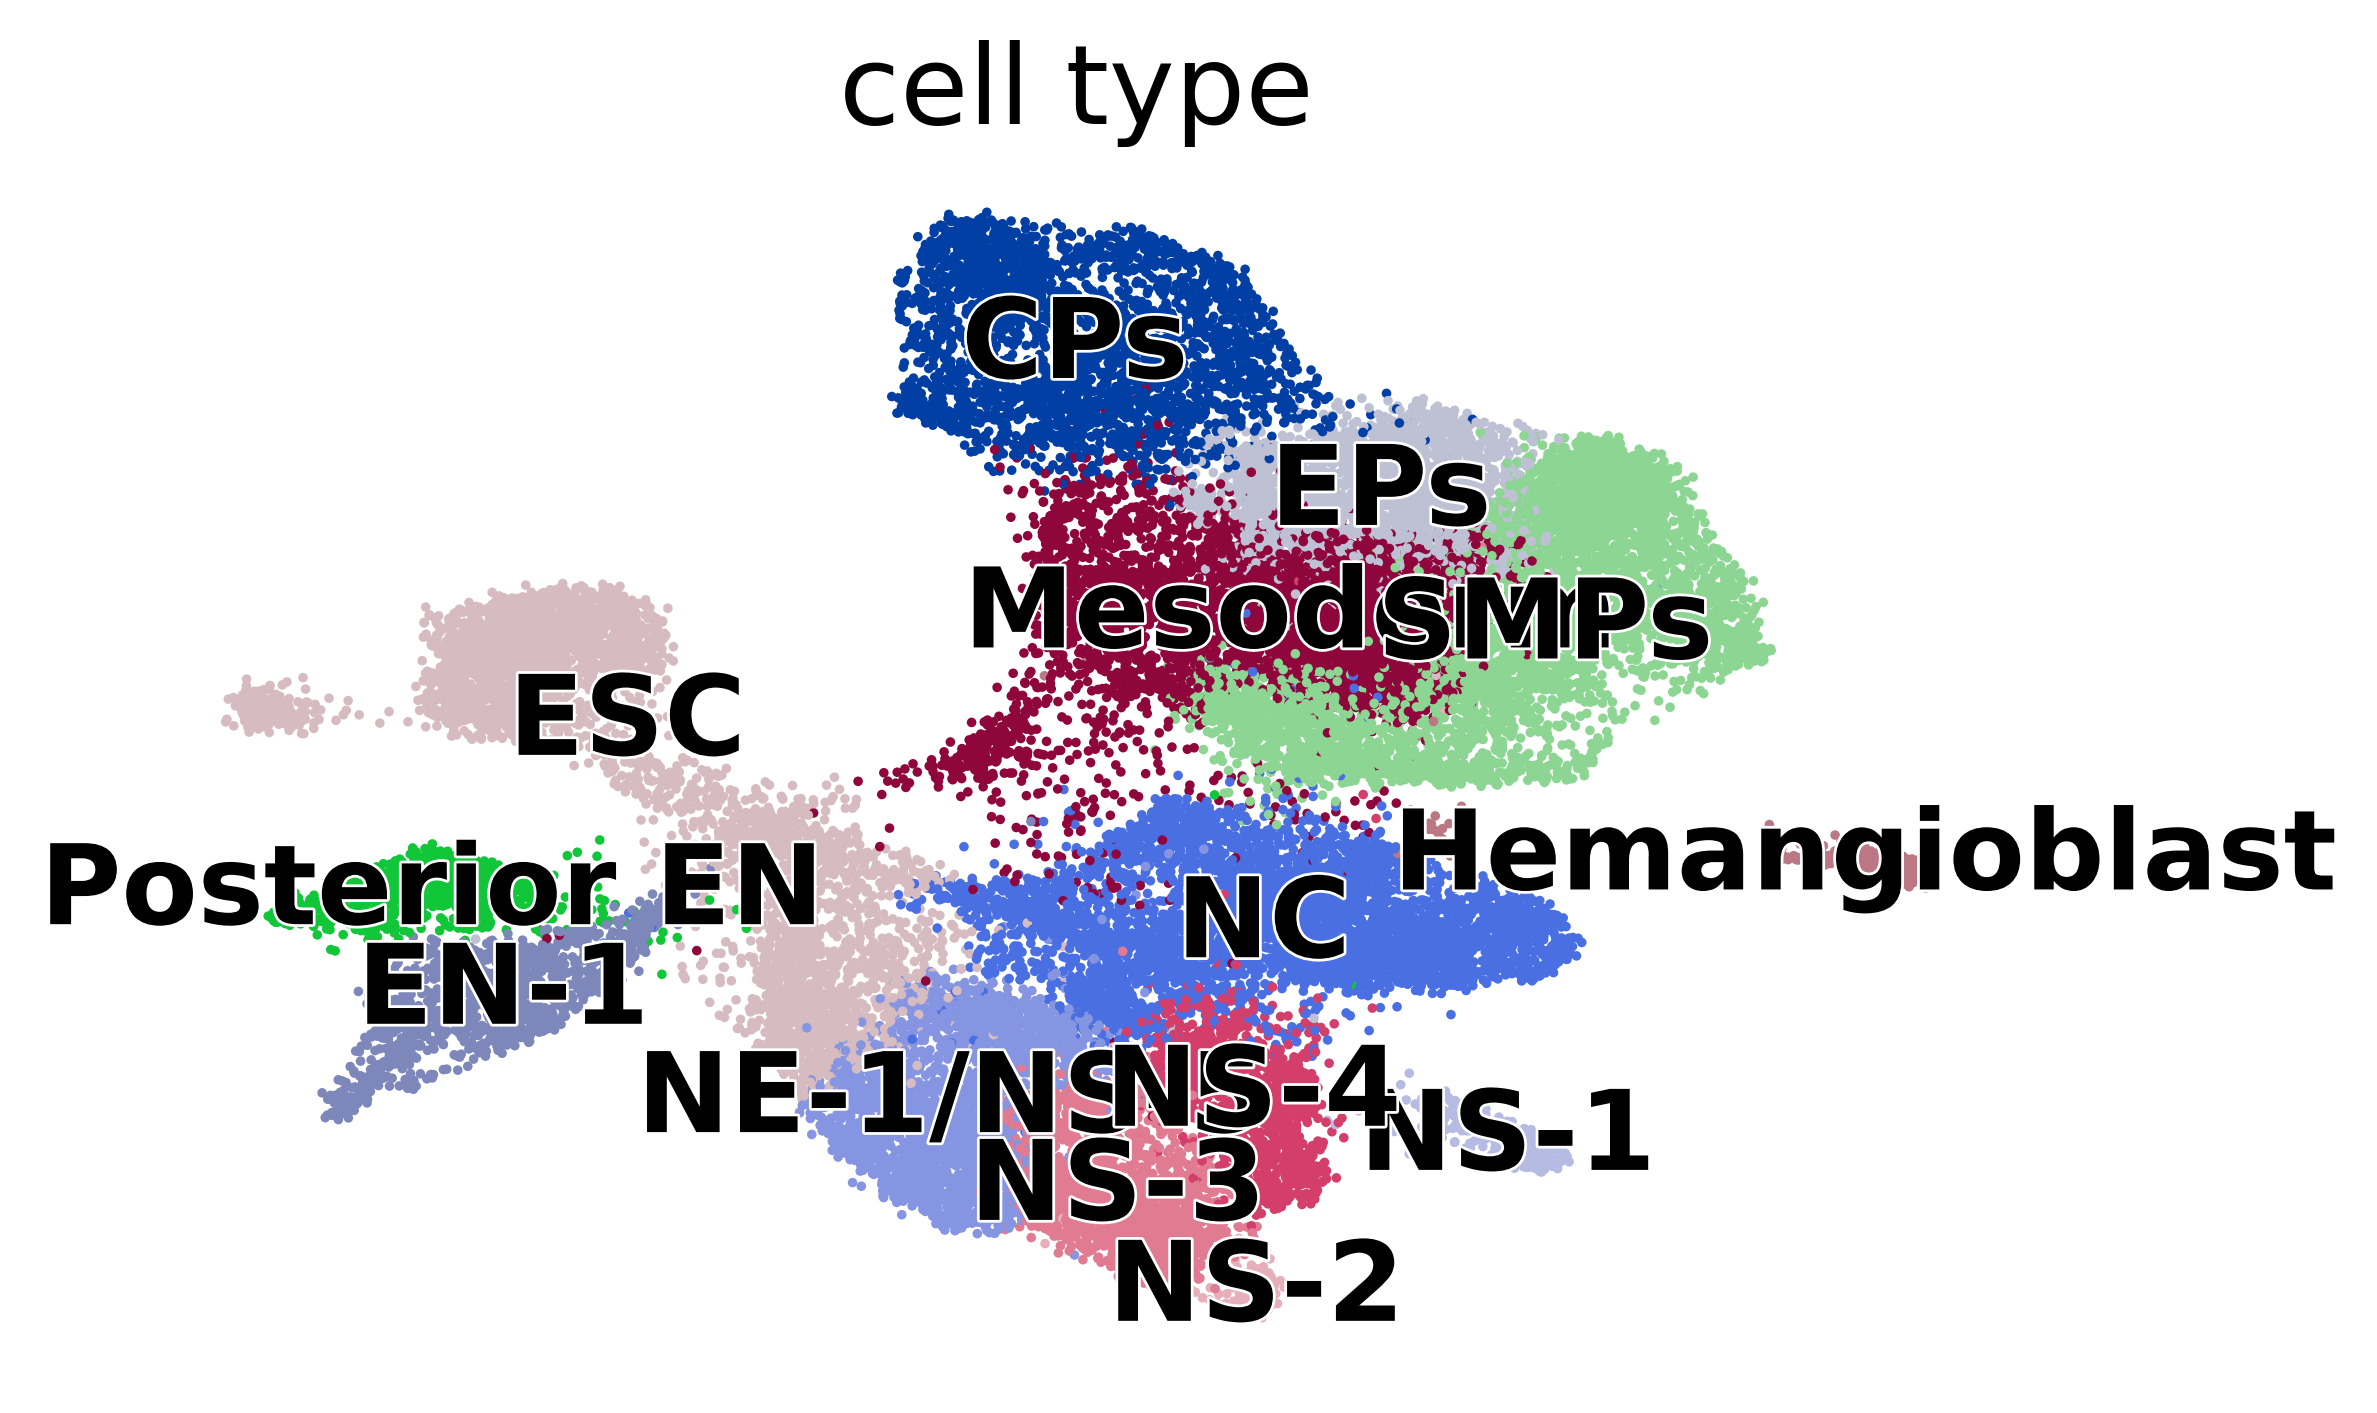

In [7]:
if running_in_notebook():
    scv.pl.scatter(adata, basis="umap", c="cell_type", dpi=200)

## Data preprocessing

In [8]:
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X

scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:37) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## CellRank

### Kernel

In [9]:
ctk = cr.kernels.CytoTRACEKernel(adata)
ctk.compute_cytotrace()

Computing CytoTRACE score with `19122` genes
DEBUG: Correlating all genes with number of genes expressed per cell
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:01)


CytoTRACEKernel[n=31029]

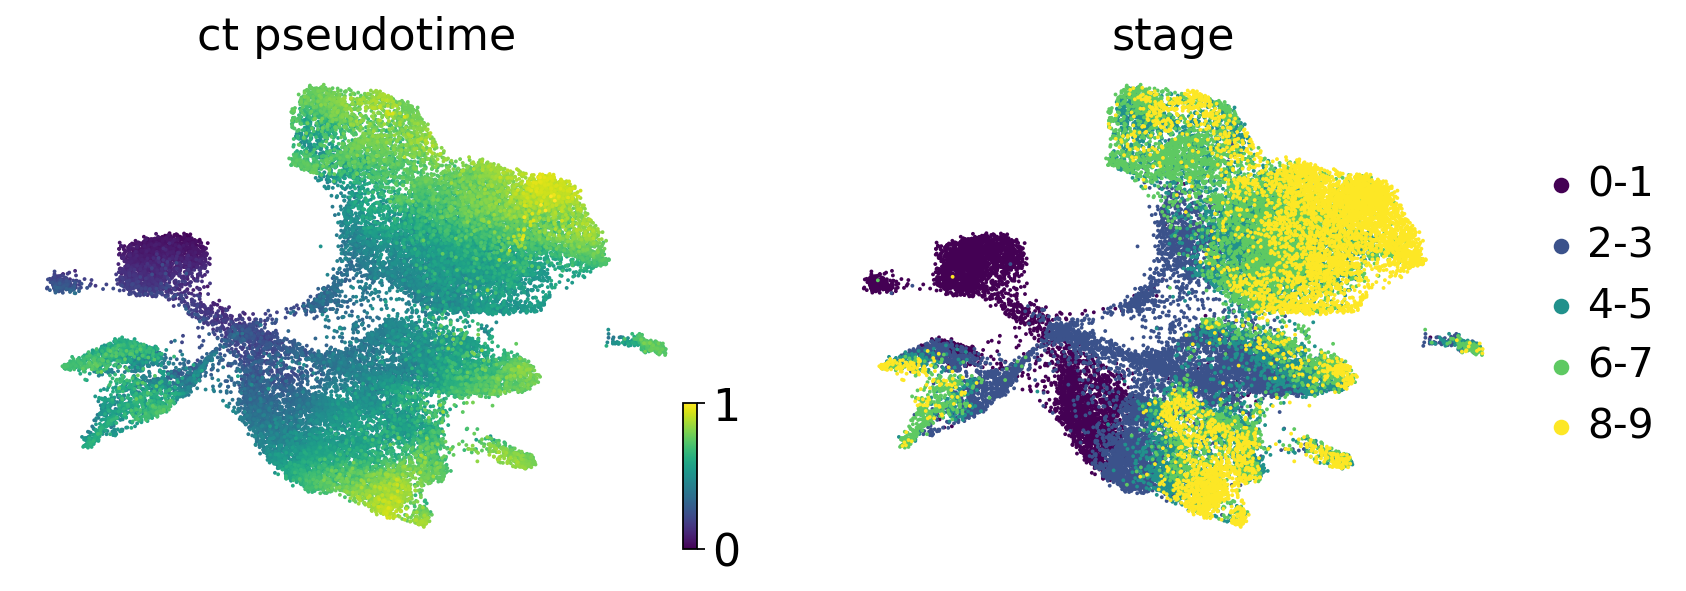

In [10]:
if running_in_notebook():
    scv.pl.scatter(
        adata,
        c=["ct_pseudotime", "stage"],
        basis="umap",
        legend_loc="right",
        color_map="viridis",
    )

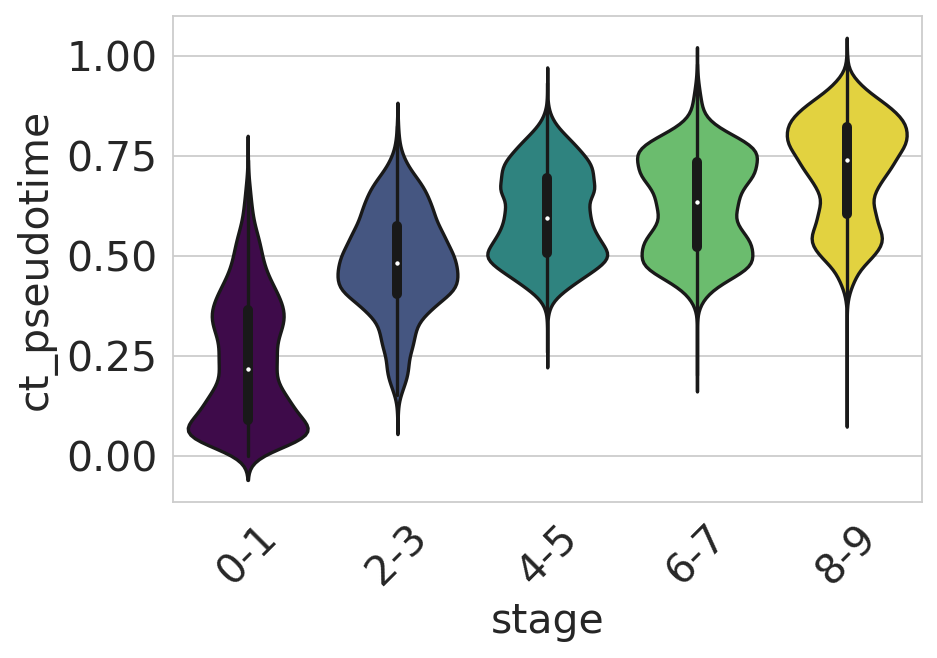

In [11]:
df = adata.obs[["ct_pseudotime", "stage"]].copy()

if running_in_notebook():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.violinplot(
        data=df,
        x="stage",
        y="ct_pseudotime",
        scale="width",
        palette=["#440154", "#3b528b", "#21918c", "#5ec962", "#fde725"],
        ax=ax,
    )

    ax.tick_params(axis="x", rotation=45)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    plt.show()
    sns.reset_orig()

In [12]:
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)
ctk.transition_matrix = ctk.transition_matrix.T

Computing transition matrix based on pseudotime


  0%|          | 0/31029 [00:00<?, ?cell/s]

    Finish (0:00:20)


### Estimator

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


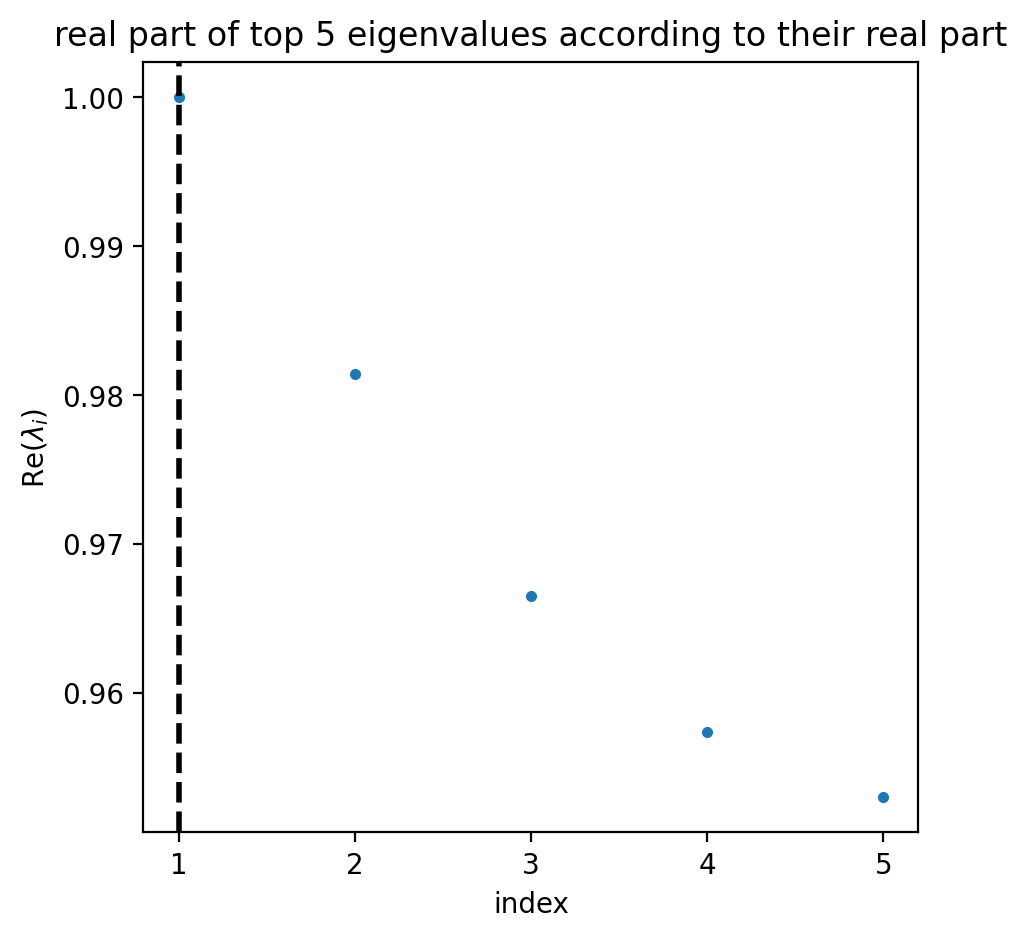

In [13]:
estimator = cr.estimators.GPCCA(ctk)
estimator.compute_schur(n_components=5)
if running_in_notebook():
    estimator.plot_spectrum(real_only=True)
    plt.show()

For 1 macrostate, stationary distribution is computed
Computing eigendecomposition of the transition matrix
DEBUG: Computing top `20` eigenvalues of a sparse matrix
DEBUG: Sorting eigenvalues by their real part
Adding `adata.uns['eigendecomposition_fwd']`
       `.eigendecomposition`
    Finish (0:00:02)
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:02)


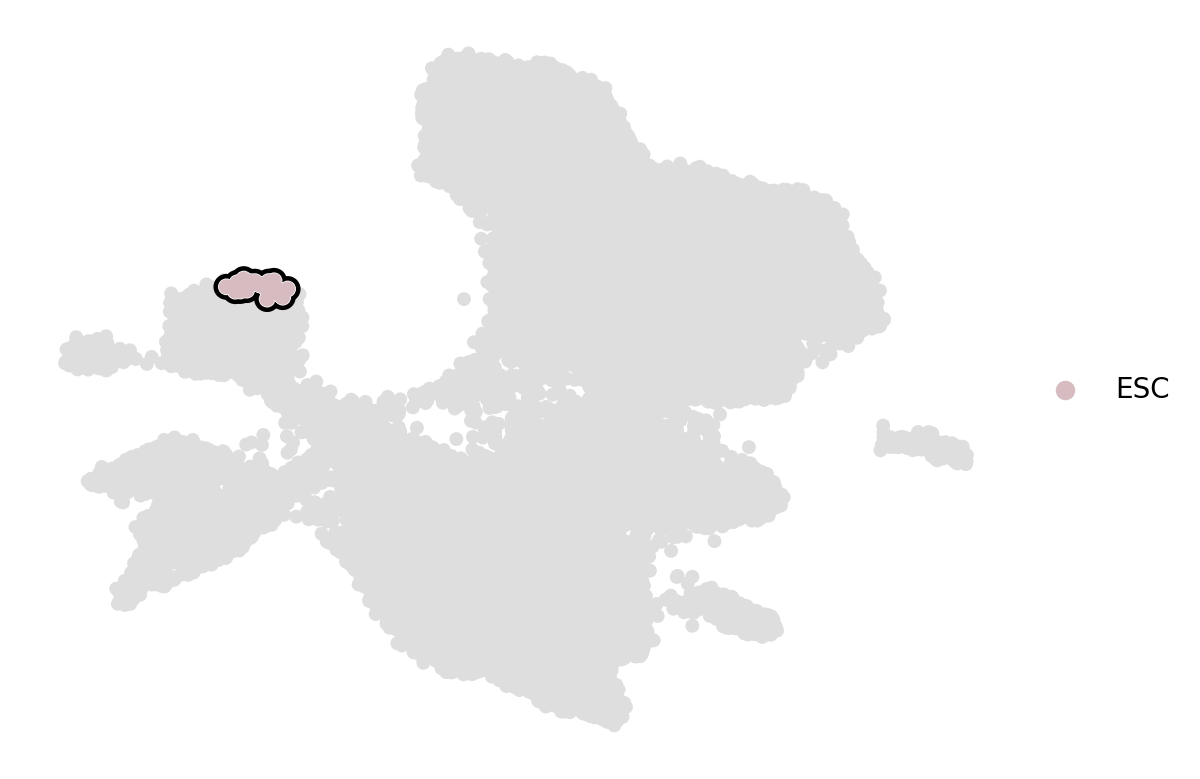

In [14]:
estimator.compute_macrostates(1, cluster_key="cell_type")

if running_in_notebook():
    estimator.plot_macrostates(which="all", basis="umap", legend_loc="right", title="", size=100)
    if SAVE_FIGURES:
        fpath = (
            FIG_DIR
            / "cytotrace_kernel"
            / "embryoid_body"
            / f"umap_colored_by_cytotrace_macrostates-initial_states.{FIGURE_FORMAT}"
        )
        estimator.plot_macrostates(which="all", basis="umap", title="", legend_loc=False, size=100, save=fpath)